In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
df = pd.read_csv("spam.csv", encoding="latin-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df = df.rename(columns={'v1':'label', 'v2':'Text'})
df['label_in_num'] = df['label'].map({'ham':0,'spam':1})
df.head()

,label,Text,label_in_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


<AxesSubplot:xlabel='label', ylabel='count'>

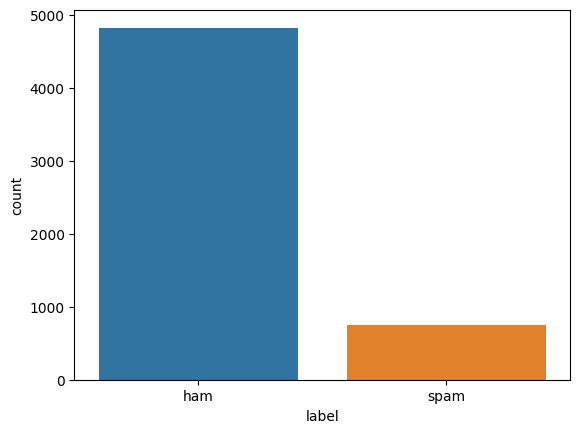

In [4]:
sns.countplot(x=df['label'])

In [5]:
df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

Text(0.5, 0, 'Text length')

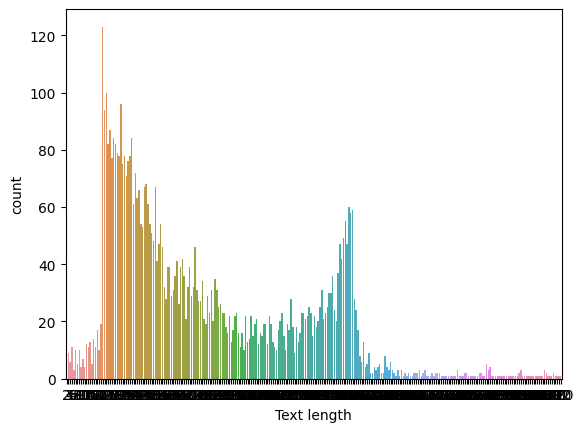

In [6]:
sns.countplot(x=[len(df.loc[i]['Text']) for i in range(len(df))])
plt.xlabel('Text length')

In [7]:
text_words_lengths = [len(df.loc[i]['Text'].split()) for i in range(0, len(df))]
total_length = np.sum(text_words_lengths)
text_words_mean = int(np.mean(text_words_lengths))
print('we have ' + str(total_length) + ' words in our Dataframe')
print('the average word count in every scentence is ' + str(text_words_mean))
text_words_lengths[:5], total_length, text_words_mean

we have 86335 words in our Dataframe
the average word count in every scentence is 15


([20, 6, 28, 11, 13], 86335, 15)

In [8]:
from sklearn.model_selection import train_test_split

X, y = np.asanyarray(df['Text']), np.asanyarray(df['label_in_num'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)
len(X_train), len(X_test), X_train[:2], y_train[:2]

(4457,
 1115,
 array(['Kallis wont bat in 2nd innings.',
        'Ringtone Club: Get the UK singles chart on your mobile each week and choose any top quality ringtone! This message is free of charge.'],
       dtype=object),
 array([0, 1], dtype=int64))

In [9]:
from sklearn.model_selection import train_test_split

X, y = np.asanyarray(df['Text']), np.asanyarray(df['label_in_num'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)
len(X_train), len(X_test), X_train[:2], y_train[:2]

(4457,
 1115,
 array(['Kallis wont bat in 2nd innings.',
        'Ringtone Club: Get the UK singles chart on your mobile each week and choose any top quality ringtone! This message is free of charge.'],
       dtype=object),
 array([0, 1], dtype=int64))

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

tfidf_vec = TfidfVectorizer().fit(X_train)
X_train_vec, X_test_vec = tfidf_vec.transform(X_train), tfidf_vec.transform(X_test)
baseline_model = RandomForestClassifier(n_estimators=250)
baseline_model.fit(X_train_vec, y_train)

random_forest_accuracy = accuracy_score(y_test, baseline_model.predict(X_test_vec))
print(classification_report(y_test, baseline_model.predict(X_test_vec)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       971
           1       1.00      0.83      0.90       144

    accuracy                           0.98      1115
   macro avg       0.99      0.91      0.95      1115
weighted avg       0.98      0.98      0.98      1115



C:\Users\nicky raj\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


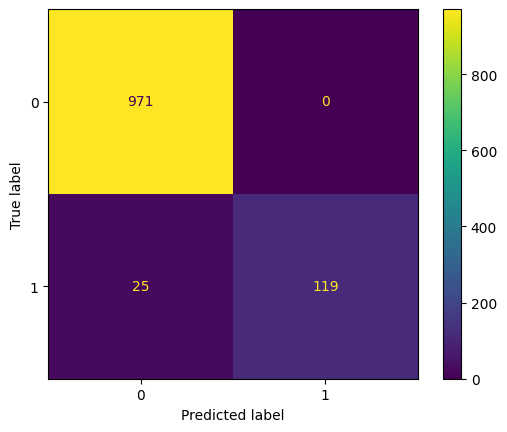

In [11]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(baseline_model, X_test_vec, y_test)

In [12]:
MAXTOKENS = total_length
OUTPUTLEN = text_words_mean

text_vec = layers.TextVectorization(
    max_tokens=MAXTOKENS,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=OUTPUTLEN
)

text_vec.adapt(X_train)

In [13]:
embedding_layer = layers.Embedding(
    input_dim=MAXTOKENS,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=OUTPUTLEN
)

In [14]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
x = layers.GlobalAveragePooling1D()(embedding_layer_model)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_1 = keras.Model(input_layer, output_layer)

In [15]:
model_1.compile(optimizer=keras.optimizers.Adam(),
               loss=keras.losses.BinaryCrossentropy(label_smoothing=0.5),
               metrics=['accuracy'])

In [16]:
history_1 = model_1.fit(X_train,
           y_train,
           epochs=5,
           validation_data=(X_test, y_test),
           validation_steps=int(0.2 * len(X_test)))

Epoch 1/5
140/140 [==============================] - 11s 73ms/step - loss: 0.6045 - accuracy: 0.9125 - val_loss: 0.5753 - val_accuracy: 0.9749
Epoch 2/5
140/140 [==============================] - 10s 72ms/step - loss: 0.5704 - accuracy: 0.9854 - val_loss: 0.5721 - val_accuracy: 0.9857
Epoch 3/5
140/140 [==============================] - 10s 72ms/step - loss: 0.5661 - accuracy: 0.9946 - val_loss: 0.5720 - val_accuracy: 0.9812
Epoch 4/5
140/140 [==============================] - 10s 72ms/step - loss: 0.5645 - accuracy: 0.9973 - val_loss: 0.5718 - val_accuracy: 0.9830
Epoch 5/5
140/140 [==============================] - 10s 72ms/step - loss: 0.5637 - accuracy: 0.9984 - val_loss: 0.5723 - val_accuracy: 0.9803


<AxesSubplot:>

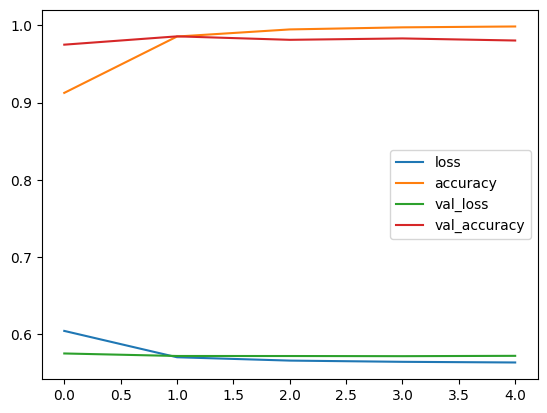

In [17]:
pd.DataFrame(history_1.history).plot()

In [18]:
def compile_model(model):
    '''
    simply compile the model with adam optimzer
    '''
    model.compile(optimizer=keras.optimizers.Adam(),
                 loss=keras.losses.BinaryCrossentropy(),
                 metrics=['accuracy'])    

def fit_model(model, epochs, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    '''
    fit the model with given epochs, train and test data
    '''
    history = model.fit(X_train,
              y_train,
             epochs=epochs,
             validation_data=(X_test, y_test),
             validation_steps=int(0.2*len(X_test)))
    return history

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model(model, X, y):
    '''
    evaluate the model and returns accuracy, precision, recall and f1-score 
    '''
    y_preds = np.round(model.predict(X))
    accuracy = accuracy_score(y, y_preds)
    precision = precision_score(y, y_preds)
    recall = recall_score(y, y_preds)
    f1 = f1_score(y, y_preds)
    
    model_results_dict = {'accuracy':accuracy,
                         'precision':precision,
                         'recall':recall,
                         'f1-score':f1}
    
    return model_results_dict

In [20]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
bi_lstm = layers.Bidirectional(layers.LSTM(64, activation='tanh', return_sequences=True))(embedding_layer_model)
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)
flatten = layers.Flatten()(lstm)
dropout = layers.Dropout(.1)(flatten)
x = layers.Dense(32, activation='relu')(dropout)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_2 = keras.Model(input_layer, output_layer)

In [21]:
compile_model(model_2)

history_2 = fit_model(model_2, epochs=5)

model_2.evaluate(X_test, y_test)

Epoch 1/5
140/140 [==============================] - 16s 87ms/step - loss: 0.0639 - accuracy: 0.9794 - val_loss: 0.0762 - val_accuracy: 0.9794
Epoch 2/5
140/140 [==============================] - 11s 80ms/step - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.0651 - val_accuracy: 0.9830
Epoch 3/5
140/140 [==============================] - 11s 80ms/step - loss: 0.0040 - accuracy: 0.9993 - val_loss: 0.0878 - val_accuracy: 0.9857
Epoch 4/5
140/140 [==============================] - 11s 79ms/step - loss: 5.0433e-05 - accuracy: 1.0000 - val_loss: 0.0930 - val_accuracy: 0.9865
Epoch 5/5
35/35 [==============================] - 1s 4ms/step - loss: 0.0964 - accuracy: 0.9865


[0.09640657901763916, 0.9865471124649048]